# Denoising with the deep decoder

The code below demonstrates the denoising performance on an example image.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


num GPUs 1


### Helper functions for displaying images

In [2]:
def myimgshow(plt, img):
    # Reshape image to channels-last, to fit matplotlib expectation.
    img = img.transpose(1, 2, 0)
    if img.shape[-1] == 1:
        # Remove channels axis for grayscale images.
        img = np.reshape(img, img.shape[:-1])
        plt.imshow(np.clip(img, 0, 1), cmap='gray')
    else:
        plt.imshow(np.clip(img, 0, 1))

def show_results(img_clean_np, img_noisy_np, img_out_np):
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 

    ax1 = fig.add_subplot(131)
    myimgshow(ax1,img_clean_np) 
    ax1.set_title('Original image')
    ax1.axis('off')

    ax2 = fig.add_subplot(132)
    myimgshow(ax2,img_noisy_np)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_np, img_noisy_np) )
    ax2.axis('off')
    
    ax3 = fig.add_subplot(133)
    myimgshow(ax3, img_out_np)
    ax3.set_title("Deep-Decoder denoised image, SNR: %.2f" % psnr(img_clean_np, img_out_np)) 
    ax3.axis('off')    

    plt.show()

## Load image

This function loads an image from the `test_data` directory, and returns:
  * numpy array of the image's pixel values.
  * a torch.Variable which refers to the numpy array.

Try "phantom256.png" or "astronaut.png".

In [3]:
def load_image(image="astronaut.png", size=None):
    img_path = './test_data/' + image
    img_pil = Image.open(img_path)
    if size is not None:
        img_pil = img_pil.resize((size, size), Image.ANTIALIAS)
    img_np = pil_to_np(img_pil)
    img_clean_var = np_to_var(img_np).type(dtype)
    return img_np, img_clean_var

Image shape: (3, 1024, 1024)
Image shape: (1, 6, 6)


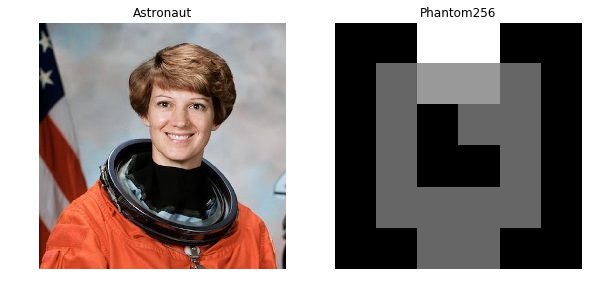

In [4]:
img_np, img_var = load_image("astronaut.png", size=1024)
print("Image shape: %s" % str(img_np.shape))

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 

ax1 = fig.add_subplot(131)
myimgshow(ax1, img_np)
ax1.set_title('Astronaut')
ax1.axis('off')

img_np, img_var = load_image("phantom256.png", size=6)
print("Image shape: %s" % str(img_np.shape))

ax1 = fig.add_subplot(132)
myimgshow(ax1, img_np)
ax1.set_title('Phantom256')
ax1.axis('off')

plt.show()

### Expected output
```
Image shape: (3, 1024, 1024)
Image shape: (1, 12, 12)
```

## Generate noisy image

Takes in a numpy array image and adds noise.

Returns:
 * A numpy array of the noisy image.
 * A torch.Variable of the noisy image.
 * The output depth (as an int) of the image. For RGB images this is 3, for grayscale it's 1.

In [5]:
def generate_noisy_image(orig_img_np, sigma=30, independent_channels=False):
    # Because our image is normalized, sigma must be scaled.
    sigma = sigma/255.0

    if independent_channels:
        # Create independent noise in each channel
        noise = np.random.normal(scale=sigma, size=orig_img_np.shape)
    else:
        # Create identical noise in each channel
        noise = np.random.normal(scale=sigma, size=orig_img_np.shape[1:])
        noise = np.array( [noise]*orig_img_np.shape[0] )

    # Add noise to image.
    img_noisy_np = np.clip(orig_img_np + noise , 0, 1).astype(np.float32)
    img_noisy_var = np_to_var(img_noisy_np).type(dtype)

    output_depth = orig_img_np.shape[0] 
    print("Image size: ", orig_img_np.shape)
    
    return img_noisy_np, img_noisy_var, output_depth

Image size:  (3, 512, 512)
Image shape: (3, 512, 512)
Image size:  (1, 256, 256)
Image shape: (1, 256, 256)


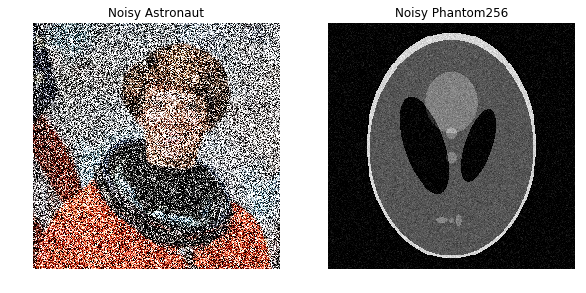

In [6]:
img_np, img_var = load_image("astronaut.png")
img_noisy_np, img_noisy_var, output_depth = generate_noisy_image(img_np, sigma=150)
print("Image shape: %s" % str(img_np.shape))

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 

ax1 = fig.add_subplot(131)
myimgshow(ax1, img_noisy_np)
ax1.set_title('Noisy Astronaut')
ax1.axis('off')

img_np, img_var = load_image("phantom256.png", size=256)
img_noisy_np, img_noisy_var, output_depth = generate_noisy_image(img_np, sigma=0.3)
print("Image shape: %s" % str(img_noisy_np.shape))

ax1 = fig.add_subplot(132)
myimgshow(ax1, img_noisy_np)
ax1.set_title('Noisy Phantom256')
ax1.axis('off')

plt.show()

## Denoise noisy image

In [7]:
def denoise_image(img_noisy_var,
                  img_clean_var,
                  output_depth,
                  iterations=1000,
                  
                  alpha=0.01,
                  regularization_noise=0.015,
                  opt_input=False,
                  reg_noise_std=0.015,
                  reg_noise_decayevery=100000,
                  mask_var=None,
                  apply_f=None,
                  decaylr=False,
                  net_input=None,
                  net_input_gen="random",
                  find_best=False,
                  
                  num_channels_up=[128]*5, 
                  filter_size_up=1,
                  need_sigmoid=True, 
                  pad='reflection', 
                  upsample_mode='bilinear', 
                  act_fun=nn.ReLU(),
                  bn_before_act = False,
                  bn_affine = True,
                  ):

    net = decodernw(
        num_output_channels = output_depth, 
        num_channels_up = num_channels_up, 
        filter_size_up = filter_size_up,
        need_sigmoid = need_sigmoid, 
        pad = pad, 
        upsample_mode = upsample_mode, 
        act_fun = act_fun,
        bn_before_act = bn_before_act,
        bn_affine = bn_affine).type(dtype)
    
    mse_n, mse_t, ni, net = fit(
        net = net,
        img_noisy_var = img_noisy_var,
        num_channels = num_channels_up,
        img_clean_var = img_clean_var,
        num_iter = iterations,
        LR = alpha,
        OPTIMIZER = 'adam',
        opt_input = opt_input,
        reg_noise_std = reg_noise_std,
        reg_noise_decayevery = reg_noise_decayevery,
        mask_var = mask_var,
        apply_f = apply_f,
        decaylr = decaylr,
        net_input = net_input,
        net_input_gen = net_input_gen,
        find_best=find_best)
    
    # Get the output from the network.
    
    # Random input.
    new_input = Variable(torch.zeros(ni.shape))
    new_input.data.uniform_()
    #img_out_np = net(ni.type(dtype)).data.cpu().numpy()[0]
    img_out_np = net(new_input.type(dtype)).data.cpu().numpy()[0]
    
    return img_out_np

Image size:  (4, 1024, 1024)
shape:  [1, 128, 32, 32]
optimize with adam 0.01


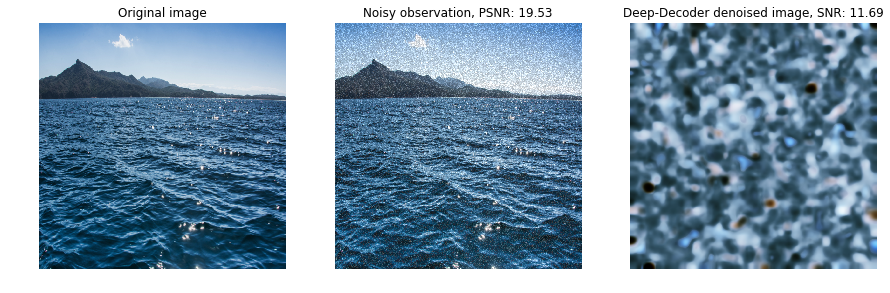

Image size:  (4, 1024, 1024)
shape:  [1, 128, 32, 32]
optimize with adam 0.01


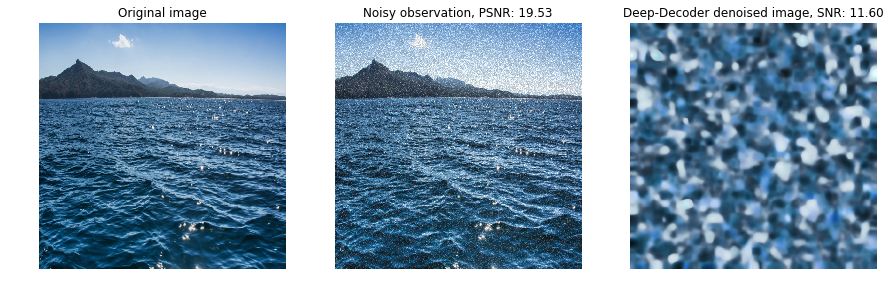

54.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [11]:
%%timeit -r 1 image = "ocean.png"

img_clean_np, img_clean_var = load_image(image, size=1024)
img_noisy_np, img_noisy_var, output_depth = generate_noisy_image(img_clean_np, sigma=30)
img_out_np = denoise_image(
    img_noisy_var,
    img_clean_var,
    output_depth,
    iterations=1000,
    reg_noise_std=0.015,
    num_channels_up=[128]*5,
    filter_size_up=1,
    need_sigmoid=True,
    pad='reflection',
    upsample_mode='bilinear',
    act_fun=nn.LeakyReLU(0.1, inplace=True),
    bn_before_act=False,
    bn_affine=True,
    alpha=0.01,
    find_best=False)
show_results(img_clean_np, img_noisy_np, img_out_np)

# Experiments

Here we try different network sizes and shapes. The `%%timeit` "magic" commands give us timing information, and the images are output with SNR scores and displayed for qualitative comparisons.

In [9]:
image = "phantom256.png"

img_clean_np, img_clean_var = load_image(image)
img_noisy_np, img_noisy_var, output_depth = generate_noisy_image(img_clean_np, sigma=1)

Image size:  (1, 256, 256)


With channels: [128, 128, 128, 128, 128]
shape:  [1, 128, 8, 8]
optimize with adam 0.01


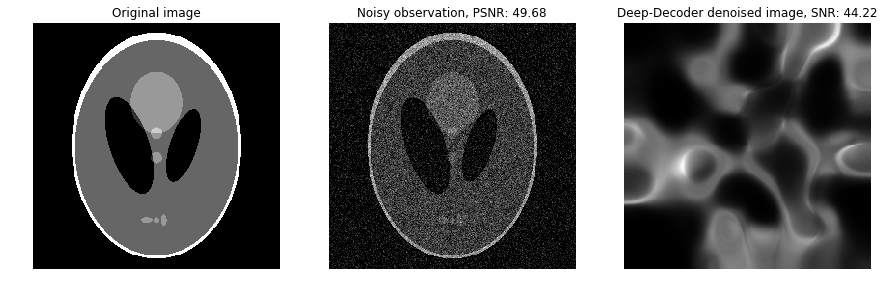

With channels: [128, 128, 128, 128, 128]
shape:  [1, 128, 8, 8]
optimize with adam 0.01


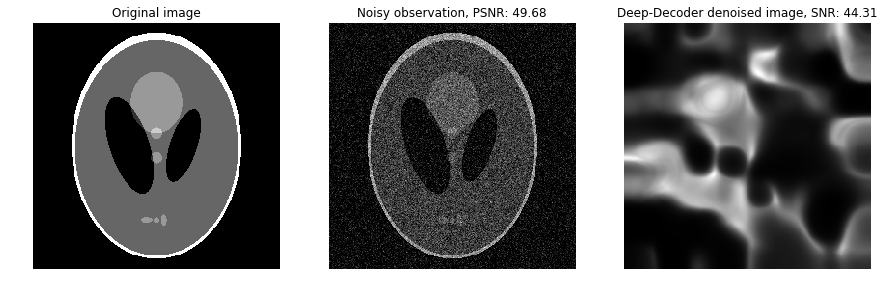

7.55 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
%%timeit -r 1 channels=[128]*5

print("With channels: %s" % (str(channels)))
img_out_np = denoise_image(img_noisy_var,
                           img_clean_var,
                           output_depth,
                           num_channels_up=channels,
                           iterations=1000)
show_results(img_clean_np, img_noisy_np, img_out_np)